In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
import operator
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor  # wrapper
import scipy.stats as st

In [2]:
df=pd.read_csv('data.csv', header=0, names=['variable','date_time','value'], index_col=1, parse_dates=True)

In [3]:
df.head()

,variable,value
date_time,,
2021-11-01 00:04:32,generationPower,-0.016
2021-11-01 00:09:34,generationPower,-0.015
2021-11-01 00:14:36,generationPower,-0.015
2021-11-01 00:19:38,generationPower,-0.015
2021-11-01 00:24:40,generationPower,-0.015


In [4]:
df.index

DatetimeIndex(['2021-11-01 00:04:32', '2021-11-01 00:09:34',
               '2021-11-01 00:14:36', '2021-11-01 00:19:38',
               '2021-11-01 00:24:40', '2021-11-01 00:29:42',
               '2021-11-01 00:34:44', '2021-11-01 00:39:46',
               '2021-11-01 00:44:48', '2021-11-01 00:49:50',
               ...
               '2021-10-31 22:13:47', '2021-10-31 22:18:49',
               '2021-10-31 22:23:51', '2021-10-31 22:28:53',
               '2021-10-31 22:33:55', '2021-10-31 22:38:57',
               '2021-10-31 22:43:59', '2021-10-31 22:49:01',
               '2021-10-31 22:54:03', '2021-10-31 22:59:05'],
              dtype='datetime64[ns]', name='date_time', length=49885, freq=None)

In [5]:
l_df=df.loc[df['variable'] == 'loadsPower']

In [6]:
data=l_df.drop(['variable'],axis=1)

In [7]:
data = data.sort_index()

In [8]:
data.head()

,value
date_time,
2021-10-10 16:12:32,0.172
2021-10-10 16:17:34,0.190
2021-10-10 16:22:36,0.168
2021-10-10 16:27:38,0.167
2021-10-10 16:32:40,0.172


In [9]:
load_val=data['value']
shifted = load_val.shift(1)

window1=shifted.rolling(window=6)
means1=window1.mean()

window2=shifted.rolling(window=12)
means2=window2.mean()

new_data=pd.concat([load_val, means1, means2], axis=1)
new_data.columns=['value','roll_mean_6', 'roll_mean_12']

In [10]:
new_data.head(15)

,value,roll_mean_6,roll_mean_12
date_time,,,
2021-10-10 16:12:32,0.172,NaN,NaN
2021-10-10 16:17:34,0.190,NaN,NaN
2021-10-10 16:22:36,0.168,NaN,NaN
2021-10-10 16:27:38,0.167,NaN,NaN
2021-10-10 16:32:40,0.172,NaN,NaN
2021-10-10 16:37:42,0.167,NaN,NaN
2021-10-10 16:42:44,0.160,0.172667,NaN
2021-10-10 16:47:46,0.173,0.170667,NaN
2021-10-10 16:52:48,0.165,0.167833,NaN


In [11]:
new_data.isna().sum()

value            0
roll_mean_6      6
roll_mean_12    12
dtype: int64

In [12]:
data=new_data.fillna(0)

In [13]:
data.isna().sum()

value           0
roll_mean_6     0
roll_mean_12    0
dtype: int64

In [14]:
data.head()

,value,roll_mean_6,roll_mean_12
date_time,,,
2021-10-10 16:12:32,0.172,0.0,0.0
2021-10-10 16:17:34,0.190,0.0,0.0
2021-10-10 16:22:36,0.168,0.0,0.0
2021-10-10 16:27:38,0.167,0.0,0.0
2021-10-10 16:32:40,0.172,0.0,0.0


In [9]:
def date_transform(df, encode_cols):
    # extract a few features from datetime
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['WeekofYear'] = df.index.weekofyear
    df['DayofWeek'] = df.index.weekday
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute
    # one hot encoder for categorical variables
    for col in encode_cols:
        df[col] = df[col].astype('category')
        
    df = pd.get_dummies(df, columns=encode_cols)
    
    return df

In [10]:
encode_cols = ['Month', 'DayofWeek', 'Hour']
bucket_size="60T"

def bucket_avg(ts, bucket):
    # ts is Sereis with index
    # bucket =["30T","60T","M".....]
    y = ts.resample(bucket).mean()
    return y

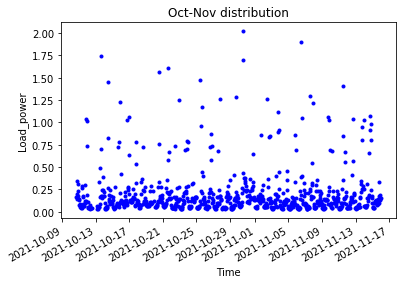

In [58]:
G_power=data["value"]
#G_power_sort=G_power.sort_values('index')

df = pd.DataFrame(bucket_avg(G_power,bucket_size))
df.dropna(inplace=True)

df.value.plot(style='b.')
plt.ylabel('Load_power')
plt.xlabel('Time')
plt.title("Oct-Nov distribution")
plt.savefig( 'EDA_2021.png', dpi=300)
plt.show()

In [11]:
def feature_importance_plot(importance_sorted, title):
    df = pd.DataFrame(importance_sorted, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    plt.figure()
    # df.plot()
    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(12, 10))
    plt.title('Feature Importance')
    plt.xlabel('relative importance')
    plt.tight_layout()
    plt.savefig(title + '.png', dpi=300)
    plt.show()

In [12]:
def xgb_importance(df, test_ratio, xgb_params, ntree, early_stop, plot_title):
    df = pd.DataFrame(df)
    # split the data into train/test set
    Y = df.iloc[:, 0]
    X = df.iloc[:, 1:]
    X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=test_ratio,
                                                        random_state=42)

    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'validate')]

    xgb_model = xgb.train(xgb_params, dtrain, ntree, evals=watchlist, early_stopping_rounds=early_stop, verbose_eval=5)

    importance = xgb_model.get_fscore()
    importance_sorted = sorted(importance.items(), key=operator.itemgetter(1))
    feature_importance_plot(importance_sorted, plot_title)


In [13]:
def get_unseen_data(unseen_start, steps, encode_cols, bucket_size):
    index = pd.date_range(unseen_start, periods=steps, freq=bucket_size)
    
    df = pd.DataFrame(pd.Series(np.zeros(steps), index=index),
                      columns=['value'])
    return df

In [21]:
def xgb_data_split(df, bucket_size, unseen_start_date, steps, test_start_date, encode_cols):
    # generate unseen data
    unseen = get_unseen_data(unseen_start_date, steps,encode_cols, bucket_size)
    
    df = pd.concat([df, unseen], axis=0)
    
    df = date_transform(df, encode_cols)

    # data for forecast ,skip the connecting point
    df_unseen = df[unseen_start_date:].iloc[:, 1:]
    test_start = '2021-11-13 18:01:54'
    # skip the connecting point
    df_test = df[test_start_date: unseen_start_date].iloc[:-1, :]
    df_train = df[:test_start_date]
    return df_unseen, df_test, df_train

In [ ]:
def add_lag(data, column, lag):
    column = data[column]
    shifted=load_val.shift(1)
    
    window= shifted.rolling(window=lag)
    means=window.mean()

    return means

In [17]:
#add rolling window

def xgb_data_split(df, bucket_size, unseen_start_date, steps, test_start_date, encode_cols):
    # generate unseen data
    unseen = get_unseen_data(unseen_start_date, steps,encode_cols, bucket_size)
    df = pd.concat([df, unseen], axis=0)
    
    means1=add_lag(df,'value',6)
    means2=add_lag(df,'value',12)
    
    new_data=pd.concat([load_val, means1, means2], axis=1)
    new_data.columns=['value','roll_mean_6', 'roll_mean_12']
    df=new_data.fillna(0)
    
    df = date_transform(df, encode_cols)
  
    # data for forecast ,skip the connecting point
    df_unseen = df[unseen_start_date:].iloc[:, 1:]
    test_start = '2021-11-13 18:01:54'
    # skip the connecting point
    df_test = df[test_start_date: unseen_start_date].iloc[:-1, :]
    df_train = df[:test_start_date]
    return df_unseen, df_test, df_train

In [15]:
test_start_date = '2021-11-13 18:01:54'
unseen_start_date = '2021-11-14 18:06:54'
steps = 200
bucket_size='5T'
encode_cols = ['Month', 'DayofWeek', 'Hour']

#unseen=get_unseen_data(unseen_start_date, steps, encode_cols, bucket_size='5T')

In [18]:
# get splited data
bucket_size='5T'
df_unseen, df_test, df = xgb_data_split(data, bucket_size, unseen_start_date, steps, test_start_date, encode_cols)

print('\n-----Xgboost on only datetime information---------\n')

dim = {'train and validation data ': df.shape,
       'test data ': df_test.shape,
       'forecasting data ': df_unseen.shape}
print(pd.DataFrame(list(dim.items()), columns=['Data', 'dimension']))


-----Xgboost on only datetime information---------

                         Data   dimension
0  train and validation data   (9337, 39)
1                  test data    (286, 39)
2           forecasting data    (200, 38)


In [21]:
df.head()

,value,roll_mean_6,roll_mean_12,Year,WeekofYear,Minute,Month_10,Month_11,DayofWeek_0,DayofWeek_1,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
2021-10-10 16:12:32,0.172,0.0,0.0,2021,40,12,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-10-10 16:17:34,0.190,0.0,0.0,2021,40,17,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-10-10 16:22:36,0.168,0.0,0.0,2021,40,22,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-10-10 16:27:38,0.167,0.0,0.0,2021,40,27,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-10-10 16:32:40,0.172,0.0,0.0,2021,40,32,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [22]:
# train model
test_ratio=0.3

Y = df.iloc[:, 0]
X = df.iloc[:, 1:]
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=test_ratio,
                                                  random_state=42)

X_test = xgb.DMatrix(df_test.iloc[:, 1:])
Y_test = df_test.iloc[:, 0]
X_unseen = xgb.DMatrix(df_unseen)

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)
watchlist = [(dtrain, 'train'), (dval, 'validate')]

In [23]:
params_sk = {
    'objective': 'reg:linear',
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'seed': 42}

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

params_grid = {"n_estimators": st.randint(100, 500),
               #                "colsample_bytree": st.beta(10, 1),
               #                "subsample": st.beta(10, 1),
               #                "gamma": st.uniform(0, 10),
               #                'reg_alpha': st.expon(0, 50),
               #                "min_child_weight": st.expon(0, 50),
               #               "learning_rate": st.uniform(0.06, 0.12),
               'max_depth': st.randint(6, 30)
               }
search_sk = RandomizedSearchCV(
    skrg, params_grid, cv=5, random_state=1, n_iter=20)  # 5 fold cross validation
search_sk.fit(X, Y)

[15:09:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:18

[15:13:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:18

[15:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:18

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.85, enable_categorical=False,
       gamma=0, gpu_id=-1, importance_type=None,
       interaction_constraints='', learning_rate=0.300000012,
       max_delta_step=0, max_depth=...1,
       seed=42, subsample=0.8, tree_method='exact', validate_parameters=1,
       verbosity=None),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001759DB82470>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001759C62DB70>},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [24]:
# best parameters
print("best parameters:", search_sk.best_params_)
print("best score:", search_sk.best_score_)

early_stop = 50

# with new parameters
params_new = {**params_sk, **search_sk.best_params_}

model_final = xgb.train(params_new, dtrain, evals=watchlist, early_stopping_rounds=early_stop, verbose_eval=True)


best parameters: {'max_depth': 28, 'n_estimators': 413}
best score: 0.03606273599336847
[15:19:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.41277	validate-rmse:0.44949
[1]	train-rmse:0.32784	validate-rmse:0.41258
[2]	train-rmse:0.26662	validate-rmse:0.39613
[3]	train-rmse:0.22474	validate-rmse:0.38849
[4]	train-rmse:0.18810	validate-rmse:0.38705
[5]	train-rmse:0.15971	validate-rmse:0.38776
[6]	train-rmse:0.13748	validate-rmse:0.38500

-----Xgboost Using Datetime Features Only------ 
---Grid Search model feature importance---


<Figure size 432x288 with 0 Axes>

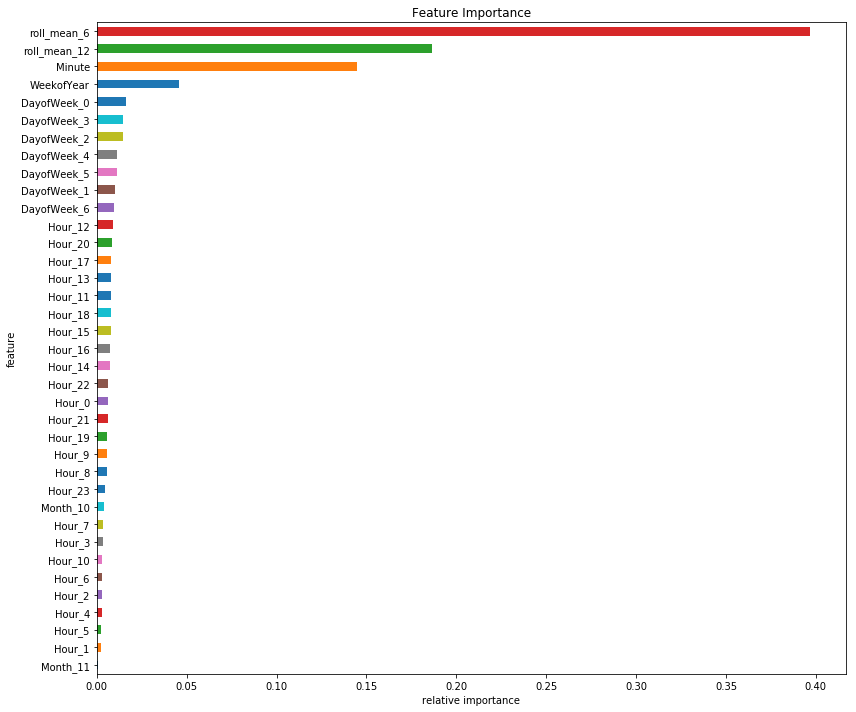

In [25]:
print('-----Xgboost Using Datetime Features Only------',
      '\n---Grid Search model feature importance---')

importance = model_final.get_fscore()
importance_sorted = sorted(importance.items(), key=operator.itemgetter(1))
fig1 = feature_importance_plot(importance_sorted, 'feature importance')
plt.show()

In [26]:
def xgb_forecasts_plot(plot_start, Y, Y_test, Y_hat, forecasts, title):
    Y = pd.concat([Y, Y_test])
    ax = Y[plot_start:].plot(label='observed', figsize=(15, 10))
    #Y_test.plot(label='test_observed', ax=ax)
    Y_hat.plot(label="predicted", ax=ax)
    forecasts.plot(label="forecast", ax=ax)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(Y_test.index[0]), Y_test.index[-1], alpha=.1, zorder=-1)
    ax.set_xlabel('Time')
    ax.set_ylabel('Global Active Power')
    plt.legend()
    plt.tight_layout()
    plt.savefig(title + '.png', dpi=300)
    plt.show()

-----Xgboost Using Datetime Features Only------ 
---Forecasting from Grid Search---


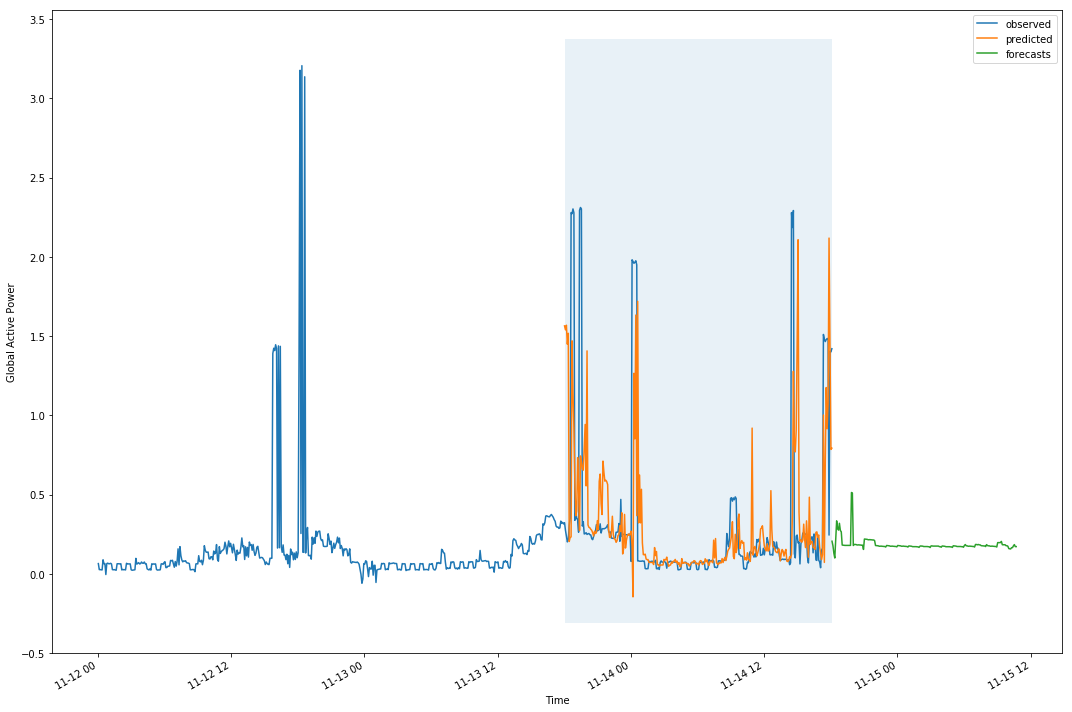

In [27]:
# Forcasting
# prediction to testing data
Y_hat = model_final.predict(X_test)
Y_hat = pd.DataFrame(Y_hat, index=Y_test.index, columns=["predicted"])

# predictions to unseen future data
unseen_y = model_final.predict(X_unseen)
forecasts = pd.DataFrame(unseen_y, index=df_unseen.index, columns=["forecasts"])

# plot forcast results using grid search final model
plot_start = '2021-11-12 00:01:54'

print('-----Xgboost Using Datetime Features Only------',
      '\n---Forecasting from Grid Search---')

forecasts_plot2 = xgb_forecasts_plot(plot_start, Y, Y_test, Y_hat, forecasts, 'Grid Search')